# 27. LLM Trend Note 2 [프로젝트_03]
<br>

## 27-1. 프로젝트: KoChatGPT 업그레이드 하기
<br>

#### 필수 requirement 설치 여부 확인
<br>

In [1]:
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

Torch version:1.12.1
Cuda version: 11.3
transformers                  4.28.0


<br><br>

### Base model (Ko-GPT-Trinity 1.2B로 foundation model 교체)
<br>

In [3]:
# 허깅페이스의 transformers를 사용해 토크나이저와 모델 불러오기

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/ko-gpt-trinity-1.2B-v0.5"

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

<br>

In [5]:
# ko-gpt-trinity-1.2B 모델의 tokenizer가 입력받아 처리 가능한 최대 토큰 수 확인

In [6]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

<br>

### 단계별( SFT, RM, PPO) 데이터셋 확인 및 EDA
<br>

#### 01-1 데이터셋(SFT) 확인
<br>

In [7]:
# 데이터 로드

In [8]:
import json 
data_path_1_SFT = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [9]:
print(len(list_data_dict))

12000


In [10]:
list_data_dict[:1]

[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193}]

<br>

#### 01-2 데이터셋(SFT) EDA
<br>

In [11]:
# 문체 분석

In [12]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [13]:
# 문체 분석
for item in list_data_dict[:3]:
    prompt = item['prompt']
    completion = item['completion']
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    completion_tone = classify_tone(completion)
    
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    print(f"Completion: {completion} - Tone: {completion_tone}")
    print("----")

Prompt: 불고기용 고기 한우에요? - Tone: 질문형
Completion: '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다. - Tone: 서술형
----
Prompt: 쓰던 앱이 유료로 전환됐어 - Tone: 기타
Completion: '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다. - Tone: 서술형
----
Prompt: 여친이랑 다툼 - Tone: 기타
Completion: '저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다. - Tone: 서술형
----


<br>

In [14]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [15]:
# 'prompt'의 완성도 분석
complete_prompts = [item['prompt'] for item in list_data_dict if item['prompt'].endswith('.')]
incomplete_prompts = [item['prompt'] for item in list_data_dict if not item['prompt'].endswith('.')]

# 'completion'의 완성도 분석
complete_completions = [item['completion'] for item in list_data_dict if item['completion'].endswith('.')]
incomplete_completions = [item['completion'] for item in list_data_dict if not item['completion'].endswith('.')]

In [16]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")
print(f"Number of complete completions: {len(complete_completions)}")
print(f"Number of incomplete completions: {len(incomplete_completions)}")

Number of complete prompts: 588
Number of incomplete prompts: 11412
Number of complete completions: 10635
Number of incomplete completions: 1365


<br>

In [17]:
# 문장의 길이 분포 분석

In [18]:
import json 
import matplotlib.pyplot as plt

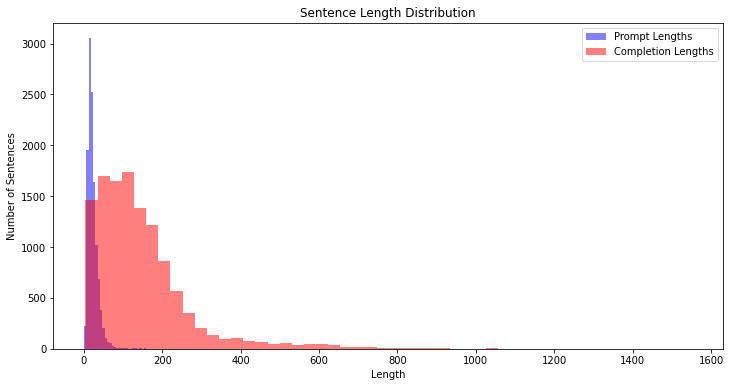

In [19]:
# 'prompt'와 'completion'의 길이를 모두 고려
lengths_prompt = [len(item['prompt']) for item in list_data_dict]
lengths_completion = [len(item['completion']) for item in list_data_dict]

plt.figure(figsize=(12, 6))

# 'prompt' 길이 분포
plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

# 'completion' 길이 분포
plt.hist(lengths_completion, bins=50, color='red', alpha=0.5, label='Completion Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

In [20]:
print(f"Original data size: {len(list_data_dict)}")

Original data size: 12000


<br>

In [21]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [22]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 50
MIN_COMPLETION_LENGTH = 5
MAX_COMPLETION_LENGTH = 300

In [23]:
filtered_data = [
    item for item in list_data_dict 
    if MIN_PROMPT_LENGTH <= len(item['prompt']) <= MAX_PROMPT_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion']) <= MAX_COMPLETION_LENGTH
]

In [24]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 10577


<br>

In [25]:
# 중복 제거 ('prompt'와 'completion' 모두를 기반으로 중복 판단)

In [26]:
seen = set()
unique_data = []
for item in filtered_data:
    combined_sentence = item['prompt'] + ' ' + item['completion']
    if combined_sentence not in seen:
        unique_data.append(item)
        seen.add(combined_sentence)

In [27]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 10577


<br>

#### 01-3 데이터셋(SFT) Augmentation
<br>

In [28]:
# nltk에서 wordnet을 사용하기 위해 필요한 데이터 다운로드

In [29]:
import random
import nltk
from nltk.corpus import wordnet

In [30]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /aiffel/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...


True

<br>

In [31]:
# Synonym Replacement: 문장 내의 단어를 그 단어의 동의어로 교체

In [32]:
def synonym_replacement(words, n=5):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalnum()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n: 
            break
    return new_words

In [33]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

<br>

In [34]:
# Random Deletion: 문장 내의 단어를 무작위로 삭제

In [35]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: 
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: 
        return [random.choice(words)]
    else:
        return remaining

<br>

In [36]:
# Random Swap: 문장 내의 두 단어의 위치를 무작위로 바꿈.

In [37]:
def random_swap(sentence, n=5): 
    length = range(len(sentence))
    if len(sentence) < 2:  # Check if the sentence has less than 2 words
        return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1]
    return sentence

<br>

In [38]:
def augment_sentence(sentence, num_new_sentences=5):
    augmented_sentences = []
    words = sentence.split(' ')
    for _ in range(num_new_sentences):
        if random.uniform(0, 1) < 0.5:
            new_sentence_words = synonym_replacement(words)
        else:
            new_sentence_words = random_swap(words)
        augmented_sentences.append(' '.join(new_sentence_words))
    return augmented_sentences

<br>

In [39]:
augmented_data = []
for item in filtered_data:
    augmented_data.append(item)
    prompt = item['prompt']
    completion = item['completion']
    for new_prompt in augment_sentence(prompt):
        new_data = item.copy()
        new_data['prompt'] = new_prompt
        augmented_data.append(new_data)
    for new_completion in augment_sentence(completion):
        new_data = item.copy()
        new_data['completion'] = new_completion
        augmented_data.append(new_data)
    if len(augmented_data) >= 15000:
        break

In [40]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 15004


<br>

#### 01-4 변경 파일(전처리+증강) 저장
<br>

In [41]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kogpt_trinity/kogpt_trinity_1_SFT.jsonl'

In [42]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br>

#### 02-1 데이터셋(RM) 확인
<br>

In [43]:
# 데이터 로드

In [44]:
data_path_2_RM = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [45]:
print(len(list_data_dict))

10220


In [46]:
list_data_dict[:2]

[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]}]

<br>

#### 02-2 데이터셋(RM) EDA
<br>

In [47]:
# 문체 분석

In [48]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [49]:
# 문체 분석
for item in list_data_dict[:2]:
    prompt = item['prompt']
    completions = [item['completion_0'], item['completion_1'], item['completion_2']]
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    
    for idx, completion in enumerate(completions, start=1):
        completion_tone = classify_tone(completion)
        print(f"Completion_{idx}: {completion} - Tone: {completion_tone}")
    
    print("----")

Prompt: 번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나? - Tone: 질문형
Completion_1: Allow me to answer your question. I know that you are curious about me. - Tone: 서술형
Completion_2: 번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다. - Tone: 서술형
Completion_3: 라이언에게 말했다. - Tone: 서술형
----
Prompt: 개포주공아파트는 몇 단지로 이루어져 있나? - Tone: 질문형
Completion_1: 개포주공아파트는 다섯 단지로 이루어져 있습니다. - Tone: 서술형
Completion_2: 이날 목송에서 구글상위노 - Tone: 기타
Completion_3: 개포주공아파트는 총 27개 단지로 이루어져 있습니다. - Tone: 서술형
----


<br>

In [50]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [51]:
# 'prompt'의 완성도 분석
complete_prompts = [item['prompt'] for item in list_data_dict if item['prompt'].endswith('.')]
incomplete_prompts = [item['prompt'] for item in list_data_dict if not item['prompt'].endswith('.')]

# 'completion'의 완성도 분석
complete_completions_0 = [item['completion_0'] for item in list_data_dict if item['completion_0'].endswith('.')]
incomplete_completions_0 = [item['completion_0'] for item in list_data_dict if not item['completion_0'].endswith('.')]

complete_completions_1 = [item['completion_1'] for item in list_data_dict if item['completion_1'].endswith('.')]
incomplete_completions_1 = [item['completion_1'] for item in list_data_dict if not item['completion_1'].endswith('.')]

complete_completions_2 = [item['completion_2'] for item in list_data_dict if item['completion_2'].endswith('.')]
incomplete_completions_2 = [item['completion_2'] for item in list_data_dict if not item['completion_2'].endswith('.')]

In [52]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")
print(f"Number of complete completions_0: {len(complete_completions_0)}")
print(f"Number of incomplete completions_0: {len(incomplete_completions_0)}")
print(f"Number of complete completions_1: {len(complete_completions_1)}")
print(f"Number of incomplete completions_1: {len(incomplete_completions_1)}")
print(f"Number of complete completions_2: {len(complete_completions_2)}")
print(f"Number of incomplete completions_2: {len(incomplete_completions_2)}")

Number of complete prompts: 495
Number of incomplete prompts: 9725
Number of complete completions_0: 6404
Number of incomplete completions_0: 3816
Number of complete completions_1: 6399
Number of incomplete completions_1: 3821
Number of complete completions_2: 6429
Number of incomplete completions_2: 3791


<br>

In [53]:
# 문장의 길이 분포 분석

In [54]:
# 'prompt'의 길이 고려
lengths_prompt = [len(item['prompt']) for item in list_data_dict]

# 각 'completion'의 길이 고려
lengths_completion_0 = [len(item['completion_0']) for item in list_data_dict]
lengths_completion_1 = [len(item['completion_1']) for item in list_data_dict]
lengths_completion_2 = [len(item['completion_2']) for item in list_data_dict]

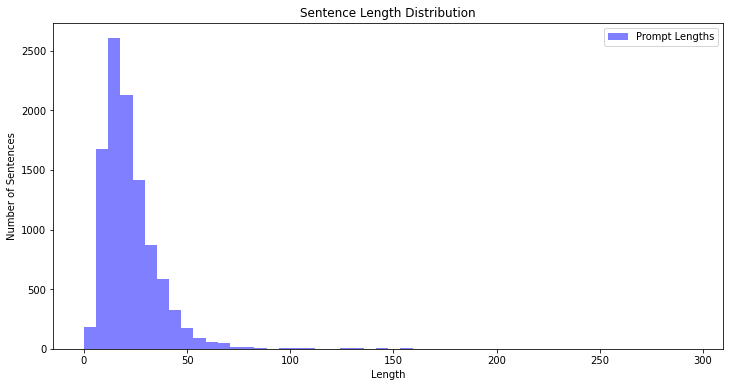

In [55]:
plt.figure(figsize=(12, 6))

# 'prompt' 길이 분포
plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

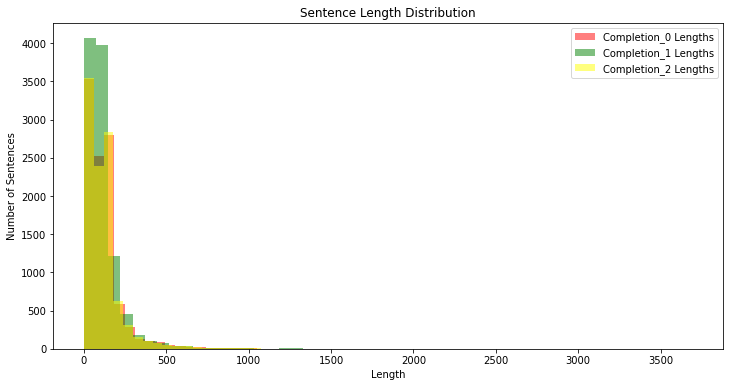

In [56]:
plt.figure(figsize=(12, 6))

# 각 'completion'의 길이 분포
plt.hist(lengths_completion_0, bins=50, color='red', alpha=0.5, label='Completion_0 Lengths')
plt.hist(lengths_completion_1, bins=50, color='green', alpha=0.5, label='Completion_1 Lengths')
plt.hist(lengths_completion_2, bins=50, color='yellow', alpha=0.5, label='Completion_2 Lengths')

plt.title('Sentence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

In [57]:
print(f"Original data size: {len(list_data_dict)}")

Original data size: 10220


<br>

In [58]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [59]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 50
MIN_COMPLETION_LENGTH = 5
MAX_COMPLETION_LENGTH = 300

In [60]:
filtered_data = [
    item for item in list_data_dict 
    if MIN_PROMPT_LENGTH <= len(item['prompt']) <= MAX_PROMPT_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_0']) <= MAX_COMPLETION_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_1']) <= MAX_COMPLETION_LENGTH
    and MIN_COMPLETION_LENGTH <= len(item['completion_2']) <= MAX_COMPLETION_LENGTH
]

In [61]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 8148


<br>

In [62]:
# 중복 제거 ('prompt'와 'completion' 모두를 기반으로 중복 판단)

In [63]:
seen = set()
unique_data = []
for item in filtered_data:
    combined_sentence = item['prompt'] + ' ' + item['completion_0'] + ' ' + item['completion_1'] + ' ' + item['completion_2']
    if combined_sentence not in seen:
        unique_data.append(item)
        seen.add(combined_sentence)

In [64]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 8148


<br>

#### 02-3 데이터셋(RM) Augmentation
<br>

In [65]:
augmented_data = []
for item in filtered_data:
    augmented_data.append(item)
    prompt = item['prompt']
    completion_0 = item['completion_0']
    completion_1 = item['completion_1']
    completion_2 = item['completion_2']

    # For prompt augmentation
    for new_prompt in augment_sentence(prompt):
        new_data = item.copy()
        new_data['prompt'] = new_prompt
        augmented_data.append(new_data)

    # For each completion augmentation
    for new_completion_0 in augment_sentence(completion_0):
        new_data = item.copy()
        new_data['completion_0'] = new_completion_0
        augmented_data.append(new_data)
    
    for new_completion_1 in augment_sentence(completion_1):
        new_data = item.copy()
        new_data['completion_1'] = new_completion_1
        augmented_data.append(new_data)
        
    for new_completion_2 in augment_sentence(completion_2):
        new_data = item.copy()
        new_data['completion_2'] = new_completion_2
        augmented_data.append(new_data)

    if len(augmented_data) >= 15000:
        break

In [66]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 15015


<br>

#### 02-4 변경 파일(전처리+증강) 저장
<br>

In [67]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kogpt_trinity/kogpt_trinity_2_RM.jsonl'

In [68]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br>

#### 03-1 데이터셋(POO) 확인
<br>

In [69]:
# 데이터 로드

In [70]:
data_path_3_PPO = '/aiffel/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

In [71]:
print(len(list_data_dict))

12000


In [72]:
list_data_dict[:5]

[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'},
 {'prompt': '페르시아로부터 기원된 아랍요리의 특징이 뭐야'},
 {'prompt': '중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?'}]

<br>

#### 03-2 데이터셋(POO) EDA
<br>

In [73]:
# 문체 분석

In [74]:
# 문체 분류를 위한 기준
def classify_tone(sentence):
    if sentence.endswith('?'):
        return "질문형"
    elif sentence.endswith('.'):
        return "서술형"
    elif sentence.endswith('!'):
        return "감탄형"
    else:
        return "기타"

In [75]:
# 문체 분석
for item in list_data_dict[:3]:
    prompt = item['prompt']
    
    # 문체 분류
    prompt_tone = classify_tone(prompt)
    print(f"Prompt: {prompt} - Tone: {prompt_tone}")
    print("----")

Prompt: 번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나? - Tone: 질문형
----
Prompt: 개포주공아파트는 몇 단지로 이루어져 있나? - Tone: 질문형
----
Prompt: 김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는? - Tone: 질문형
----


<br>

In [76]:
# 문장 완성도 분석 (예시: 마지막에 마침표가 있는지로 판단)

In [77]:
# 'prompt'의 완성도 분석
complete_prompts = [item['prompt'] for item in list_data_dict if item['prompt'].endswith('.')]
incomplete_prompts = [item['prompt'] for item in list_data_dict if not item['prompt'].endswith('.')]

In [78]:
print(f"Number of complete prompts: {len(complete_prompts)}")
print(f"Number of incomplete prompts: {len(incomplete_prompts)}")

Number of complete prompts: 588
Number of incomplete prompts: 11412


<br>

In [79]:
# 문장의 길이 분포 분석

In [80]:
lengths_prompt = [len(item['prompt']) for item in list_data_dict]

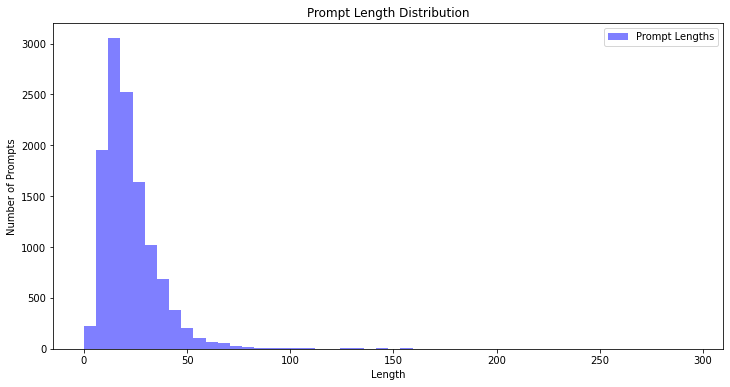

In [81]:
plt.figure(figsize=(12, 6))

plt.hist(lengths_prompt, bins=50, color='blue', alpha=0.5, label='Prompt Lengths')

plt.title('Prompt Length Distribution')
plt.xlabel('Length')
plt.ylabel('Number of Prompts')
plt.legend()
plt.show()

<br>

In [82]:
# 길이 기반 필터링 (지나치게 긴 문장이나 지나치게 짧은 문장을 제거)

In [83]:
MIN_PROMPT_LENGTH = 5
MAX_PROMPT_LENGTH = 50

In [84]:
filtered_data = [
    item for item in list_data_dict 
    if MIN_PROMPT_LENGTH <= len(item['prompt']) <= MAX_PROMPT_LENGTH
]

In [85]:
print(f"Filtered data size: {len(filtered_data)}")

Filtered data size: 11482


<br>

In [86]:
# 중복 제거

In [87]:
seen = set()
unique_data = []
for item in filtered_data:
    if item['prompt'] not in seen:
        unique_data.append(item)
        seen.add(item['prompt'])

In [88]:
print(f"Unique data size after removing duplicates: {len(unique_data)}")

Unique data size after removing duplicates: 11432


<br>

#### 03-3 데이터셋(POO) Augmentation
<br>

In [89]:
augmented_data = []
for item in filtered_data:
    augmented_data.append(item)
    prompt = item['prompt']

    # 'prompt' 증강
    for new_prompt in augment_sentence(prompt):
        new_data = item.copy()
        new_data['prompt'] = new_prompt
        augmented_data.append(new_data)

    if len(augmented_data) >= 15000:
        break

In [90]:
print(f"Augmented data size: {len(augmented_data)}")

Augmented data size: 15000


<br>

#### 03-4 변경 파일(전처리+증강) 저장
<br>

In [91]:
# 지정된 경로 및 파일명
file_path = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kogpt_trinity/kogpt_trinity_3_PPO.jsonl'

In [92]:
# 파일 쓰기 모드로 파일 열기
with open(file_path, 'w') as f:
    for item in augmented_data:
        f.write(json.dumps(item) + '\n')

<br><br>

### Supervised Fine-Tuning (SFT)
<br>

#### 필요 라이브러리 불러오기
<br>

In [93]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

<br>

#### 모델과 토크나이저 불러오기
<br>

In [94]:
model = AutoModelForCausalLM.from_pretrained('skt/ko-gpt-trinity-1.2B-v0.5')

In [95]:
tokenizer = AutoTokenizer.from_pretrained(
    'skt/ko-gpt-trinity-1.2B-v0.5', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [96]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/ko-gpt-trinity-1.2B-v0.5', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True)


<br>

#### prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스 정의 (모델 인퍼런스 단계에서 사용)
<br>

In [97]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        data_path_1_SFT = '/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kogpt_trinity/kogpt_trinity_1_SFT.jsonl'
        list_data_dict = []
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            for line in json_file:
                list_data_dict.append(json.loads(line))

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [98]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

<br>

In [99]:
train_dataset = SFT_dataset(data_path_1_SFT='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kogpt_trinity/kogpt_trinity_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [100]:
print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([30132, 42872, 33313, 30679, 40479, 39911,   384, 22509, 21921, 25372,
          385, 31245, 23280, 34957, 25617, 36539, 29991, 25624, 25400, 31167,
          376, 42872,   379, 46803,   456, 30303, 35353,   384, 25785, 20573,
        37780,   383, 46900, 43226,   565, 27071, 23151, 31555, 41690, 35071,
        25400, 31269, 32677, 30765, 31810, 36229, 30326, 33889, 30093, 34957,
        25617, 30021, 30434, 29991, 39687, 34036, 19016, 31997, 49906, 19352,
        30011, 30904, 36731, 43502, 30228, 31214, 30326, 29991, 31621, 33314,
        34347, 30843, 50342, 33512, 31370, 34243, 29991, 35144, 32586, 32622,
        44680, 30110, 21844, 39826, 34803, 31356, 39075, 30242, 36966, 29985,
        34179, 36513, 30718, 35557, 32361, 31018, 29404, 35942, 19352, 41049,
            1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -1

<br>

#### 디코딩 확인
<br>

In [224]:
# 디코딩 함수 작성

In [101]:
def decode_token_ids(token_ids, tokenizer):
    # token_ids를 Python 리스트로 변환
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    # token_ids 값을 디코딩
    decoded_text = ""
    for single_token_id in token_ids:
        # -100 값은 무시
        if single_token_id == -100:
            continue
        try:
            decoded_text += tokenizer.decode([single_token_id], skip_special_tokens=True)
        except OverflowError:
            print(f"Problematic token ID: {single_token_id}")
            raise
    
    return decoded_text

<br>

In [226]:
# 주어진 input_ids와 labels를 디코딩하여 출력

In [102]:
input_text = decode_token_ids(train_dataset.input_ids[0], tokenizer)
label_text = decode_token_ids(train_dataset.labels[0], tokenizer)

print('Decoded input:', input_text)
print('Decoded output:', label_text)

Decoded input: ###Instruction(명령어):
불고기용고기한우에요?

###Response(응답):'저는인공지능챗봇이며,직접적으로식품에관한정보를가지고있지않습니다.하지만일반적으로불고기용고기는한우,쇠고기,돼지고기등다양한종류의고기를사용합니다.하지만한우는대표적인고급육류로알려져있기때문에,한우를사용하는경우도많습니다.알러지나개별건강상태에따라다를수있으니충분한정보수집후에선택해주시기바랍니다.
Decoded output: '저는인공지능챗봇이며,직접적으로식품에관한정보를가지고있지않습니다.하지만일반적으로불고기용고기는한우,쇠고기,돼지고기등다양한종류의고기를사용합니다.하지만한우는대표적인고급육류로알려져있기때문에,한우를사용하는경우도많습니다.알러지나개별건강상태에따라다를수있으니충분한정보수집후에선택해주시기바랍니다.


<br>

#### Training arguments를 사용해 trainer 클래스 정의
<br>

In [108]:
training_args = TrainingArguments(
    output_dir="/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_trinity",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=2,  # 배치 크기를 줄임
    per_device_eval_batch_size=2,   # 배치 크기를 줄임
    gradient_accumulation_steps=4,  # 그래디언트 축적 사용
    warmup_steps=5,
    prediction_loss_only=True,
    fp16=True
)

In [109]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [112]:
# 3. 모델 및 토크나이저를 GPU에서 삭제 후 다시 로드
# del model
# torch.cuda.empty_cache()

# model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [113]:
# 4. 기타 메모리 최적화 기법
torch.backends.cudnn.benchmark = False

<br>

#### SFT 훈련
<br>

In [114]:
trainer.train()
model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_trinity/output_1_SFT_trinity')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trainer.train()                                                                              │
│   2 model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test_trinity/output_1_SF     │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1662 in train                     │
│                                                                                                  │
│   1659 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1660 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1661 │   │   )                                                                                 │
│ ❱ 1662 │   │   return inner_training_loop(                                                       │
│   1663 │   │   │   args=args,                                                                    │
│   1664 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1665 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:1929 in _inner_training_loop      │
│                                                                                                  │
│   1926 │   │   │   │   │   with model.no_sync():                                                 │
│   1927 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1928 │   │   │   │   else:                                                                     │
│ ❱ 1929 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1930 │   │   │   │                                                                             │
│   1931 │   │   │   │   if (                                                                      │
│   1932 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:2699 in training_step             │
│                                                                                                  │
│   2696 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2697 │   │                                                                                     │
│   2698 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2699 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2700 │   │                                                                                     │
│   2701 │   │   if self.args.n_gpu > 1:                                                           │
│   2702 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/transformers/trainer.py:2731 in compute_loss              │
│                                                                                                  │
│   2728 │   │   │   labels = inputs.pop("labels")           

<br>

## foundation model의 교체는 성공하였으나, 

## 메모리 부족 문제로 더 이상 학습을 진행할 수 없으므로 

## 본 과제는 여기서 종료함.

<br>

#### 문장 생성 능력 확인 (generator 생성)
<br>

In [231]:
generator = pipeline('text-generation', model='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test/output_1_SFT_revised', tokenizer=tokenizer)

In [232]:
generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

In [233]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

In [234]:
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

In [235]:
list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

In [236]:
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이며, 실제 고기를 사용하지는 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 예를 들어 소갈비찜, 오리고기 구이, 양고기 바비큐 등 다양한 고기 요리를 할 수 있습니다. 하지만 정확한 정보를 얻기 위해서는

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'1953년입니다. attracted) '1953년 있습니다. 있는 대선 여깁니다. 대통령은 위해 워드. 닉슨은 수

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 일리노이 주 시카고에 위치해 있습니다.)은 미국에서 가장 빠르게 성장하는 공항 중 하나입니다.)은 미국 일리노이 주(Stiller)에 위치해 있으며, 국제선 항공권 예약이 가능합니다.)로 검색 엔진을 통해 해당 지역의 국제공항을 찾으실

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 농도는 어제와 비교해서 개선되었지만 아직도 나쁜 수준이며, 마스크 착용과 실외 활동 자제를 권장합니다. 미세먼지 농도를 확인하려면 해당 지역의 미세먼지 측정소에서 확인해보시는 것이 좋습니다.) 나아가는 미세먼지 때문에 개선되었습니다.


<br>

#### 메모리 관리를 위해 캐시 비우기
<br>

In [237]:
torch.cuda.empty_cache()

<br><br>

### Reward Model (RM)
<br>

#### 필요 라이브러리 불러오기
<br>

In [247]:
# cd aiffel 
# git clone https://github.com/airobotlab/KoChatGPT  
# cd KoChatGPT/colossalai_ChatGPT_230319/
# pip install .  

In [246]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

<br>

#### Reward model 설계
<br>

In [248]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

<br>

#### 사용할 모델과 토크나이저 불러오기
<br>

In [249]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')

In [250]:
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

In [251]:
with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<br>

#### ranking dataset 만들기 (RM 훈련시킬 때 사용)
<br>

In [253]:
list_data_dict = []

with open('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kochatgpt/kochatgpt_2_RM_revised.jsonl', "r", encoding='utf-8-sig') as json_file:
    for line in json_file:
        list_data_dict.append(json.loads(line))

In [254]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)

    total_data_ranking2chosen.extend(one_data_ranking2chosen)

In [255]:
print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 15015
after  data num: 45045
data example: 
{'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?', 'chosen': '구글상위노 이날 목송에서', 'rejected': '개포주공아파트는 다섯 단지로 이루어져 있습니다.'}


<br>

#### 완성한 ranking dataset을 shuffle한 후 훈련셋 만들기
<br>

In [256]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '전차가 어느 회사에서 처음 시험주행했어', 'chosen': '야 한다는 것', 'rejected': '요?\n\n전차는 1911년 미국의 캐딜락 엔진 기술 개발 기업인 슈타우트 모터 스쿼드(Studebaker Motor Squadron)에서 처음 시험주행했습니다.'}


<br>

In [257]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

1000
200


In [258]:
train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

100%|██████████| 200/200 [00:00<00:00, 1405.52it/s]


<br>

In [259]:
# 데이터셋이 잘 만들어졌는지 하나를 뽑아 확인

In [260]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
가자 지구와 어느 국가가 접해 있어
######################################################################
## chosen ##
요?

가장 가까운 국가는 미국입니다.
######################################################################
## rejected ##
국내 시장 공별 결과 같은 국육 강규 등 공개의 형개인 국육 강규인 국내 국내와 국내이 남겨둥칠 국가 공개 등 국육이 각국 국내 국내와 국내의 국가 공개 개인 국육 각국 국내 국내와 국내의 국가 공개 개인


<br>

#### RM 학습
<br>

In [261]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [262]:
trainer.fit(use_lora=0)

model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test/output_2_RM_revised')

Train epoch: 100%|██████████| 1/1 [03:49<00:00, 229.90s/it]


<br>

#### RM 학습 여부 확인 (임의의 문장의 입력에 대한 reward score 출력 확인)
<br>

In [263]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

<br>

In [264]:
input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: 2.4


In [265]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'
output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: 2.9


In [266]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."
output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: 3.0


In [267]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: 2.7


<br>

#### 메모리 관리를 위해 캐시 비우기
<br>

In [268]:
torch.cuda.empty_cache()

<br><br>

### Proximal Policy Optimization (PPO)
<br>

#### 필요 라이브러리 불러오기
<br>

In [269]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

<br>

#### pretrain 모델인 kogpt-2의 토크나이저를 그대로 사용
<br>

In [270]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test/output_1_SFT_revised', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test/output_2_RM_revised', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

<br>

#### 모델학습에 사용할 옵티마이저와 모델 준비
<br>

In [271]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [272]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

<br>

#### PPO 학습에 쓸 데이터를 불러와 토크나이징
<br>

In [274]:
list_data_dict = []

with open('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/data_kochatgpt/kochatgpt_3_PPO_revised.jsonl', "r", encoding='utf-8-sig') as json_file:
    for line in json_file:
        list_data_dict.append(json.loads(line))
        
list_prompt = [tmp['prompt'] for tmp in list_data_dict]

In [275]:
def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [276]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [277]:
len(list_prompt)

15000

<br>

#### PPO 학습
<br>

In [278]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [279]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('/aiffel/aiffel/AIFFEL/09_GD_NLP/Quest_09/test/output_3_PPO_revised')

Episode [10/10]: 100%|██████████| 3/3 [00:19<00:00,  6.41s/it]


<br>

#### RLHF가 적용된 koGPT-2의 생성능력 확인
<br>

In [280]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

In [281]:
PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

In [282]:
list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

In [283]:
list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

In [284]:
for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 어시스턴트로, 답변해드리도록 노력하겠습니다.\n일반적으로 불고기용 고기는 한우와 쌀을 혼합하거나 첨가물을 사용하지 않으면서 사용됩니다. 이러한 방식으로 불고기의 사용방법을 선택하며, 부위나 종류는 직접 정보를 사용합니다. 예를 들어 생선과 쇠고기, 돼지고기 등의 쇠고기를 사용한다는 것은 가능할 수 있습니다. 하지만 개별 레시피를 따라서, 또는 부위나 지역의 요리를 따라 활용하기 때문에 고기 한우의 사용 여부는 상황에 따라 다릅니다. 참조

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'1956년입니다. 닉슨은 1960년 부통령직을 부통령 재직 당시였습니다.)한 부통령은)한 하지만 능력을 압제를 후 않았습니다. 1952년)한 수 대선) 졌습니다. 대선 '1957년

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):'시카고 오헤어 국제공항은 미국 일리노이 주 시카고에 위치해 있습니다. 현재 시카고에 가장 미국 항공 여행객들이 많은 도시는 미국 일리노이 주 시카고에 해당하는 주 시카고에 있는 공항입니다. hem\'s AI: 국제공항 (PK) heavy) atomic net bradypus transition, physical information: 미국 항공권 챗봇입니다.) 미국에서) 미국에서)를)

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 농도는 어제와 비교해서 개선되었지만 아직 나쁜 수준이며, 개선되지 않았기 때문에 측정소에서 미세먼지 농도를 확인할 수 없습니다. 미세먼지의 농도는 개선되었지만 여전히 나쁜 수준이며, 마스크 착용과 실외 활동 자제를 권장합니다. 개선되어야 할 것입니다. 개선되어야 사용됩니다.


<br><br>

## 27-2. 프로젝트 제출
<br>

### 루브릭
<br>

|<big>평가문항</big>|<big>상세기준</big>|
|:--|:--|
|<br>**1. 기존 데이터셋을 추가 정제하고, generation 성능을 끌어올리기 위한 기법들을 실험해 모델 perfomance를 향상시켜보았는가?**<br><br> | <br>기존 데이터셋의 문제점을 분석하고 전처리 전략을 수립해 추가 정제를 진행했다. Beam search, Top-k(p) sampling 등 최선의 디코딩 전략을 수립해 향상된 모델 추론 결과를 제시했다. BLEU, ROUGE 등 생성된 텍스트를 평가하기 위한 메트릭을 적용한 정량적인 평가 결과와 주관적인 평가를 비교분석하였다.<br><br> |
|<br>**2. 새로운 데이터를 수집해 전처리를 수행하여 모델을 재학습시켜보았는가?**<br><br> | <br>모두의 말뭉치, AI hub 등에 공개된 데이터를 사용해 추가 데이터셋을 구축하기 위한 기준과 근거를 수립했다. ChatGPT API나 다양한 한국어 benchmark 데이터셋을 활용해 Human Feedback 을 대체할 수 있는 아이디어를 구현했다. 위를 바탕으로 SFT, RM, PPO 세 단계에 필요한 각 데이터셋을 적절히 구축하여, 모델 추론 결과와 수립한 가설을 비교해보았다.<br><br> |
|<br>**3. 학습 전략 또는 foundation model을 변경해 모델을 재학습시켜보았는가?**<br><br> | <br>더 적절한 Instruction Tuning 기법을 적용해 SFT를 해보거나, Reward Model의 ranking algorithm을 개선해보았다. KoGPT-2가 아닌 다른 모델을 initial model로 사용하여 모델 학습을 성공시켰다. 허깅페이스의 accelerate, bitsandbytes 라이브러리 등을 사용하여 더 큰 스케일의 모델로 ChatGPT를 re-building해 모델 성능을 향상시켰다.<br><br> |